In [74]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from  keras.models import Sequential,Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [75]:
NUMBER_CLASSES  = 3

IMAGE_RESIZE = 224
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16
BATCH_SIZE_TESTING = 1

In [76]:
base_model = ResNet50(weights="imagenet",include_top=False)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [77]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000,activation="relu")(x)
x = Dropout(0.5)(x)
pred = Dense(NUMBER_CLASSES,activation="softmax")(x)

In [78]:
model = Model(inputs=base_model.input, outputs=pred)

In [79]:
for layer in model.layers[:90]:
    layer.trainable = False
for layer in model.layers[90:]:
    layer.trainable = True

In [80]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                "train/",
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_TRAINING,
                                class_mode='categorical',
                                subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
                                "train/", # same directory as training data
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_VALIDATION,
                                class_mode='categorical',
                                subset='validation') # set as validation data

Found 36 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [81]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'weights/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [82]:
model.compile(optimizer="RMSprop",loss="categorical_crossentropy", metrics=["accuracy"])

In [55]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/20
10/10 [==============================] - 84s 8s/step - loss: 2.7354 - acc: 0.6558 - val_loss: 1.7043 - val_acc: 0.3333
Epoch 2/20
10/10 [==============================] - 51s 5s/step - loss: 2.2994 - acc: 0.6411 - val_loss: 1.1046 - val_acc: 0.3333
Epoch 3/20
10/10 [==============================] - 44s 4s/step - loss: 2.2739 - acc: 0.5763 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/20
10/10 [==============================] - 47s 5s/step - loss: 2.2558 - acc: 0.5920 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/20
10/10 [==============================] - 49s 5s/step - loss: 1.1634 - acc: 0.8312 - val_loss: 10.7454 - val_acc: 0.3333


In [83]:
model.load_weights("weights/best.hdf5")

In [84]:
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
                                "test/",
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_TESTING,
                                class_mode='categorical') # set as training data

Found 9 images belonging to 3 classes.


In [85]:
#for property_, value in vars(test_generator).items():
#    print (property_, ": ", value)

In [86]:
len(test_generator.filenames )

9

In [87]:
steps = len(test_generator.filenames)/BATCH_SIZE_TESTING
result = model.predict_generator(test_generator,verbose=1,steps=steps)

9/9 [==============================] - 4s 424ms/step


In [88]:
print(result)

[[ 0.36869049  0.28766796  0.34364158]
 [ 0.36791709  0.28844267  0.34364024]
 [ 0.37250015  0.28569418  0.3418057 ]
 [ 0.36378038  0.28932178  0.34689784]
 [ 0.36445814  0.28950322  0.34603858]
 [ 0.36722824  0.28851411  0.34425762]
 [ 0.36852849  0.28928483  0.34218669]
 [ 0.36974147  0.28779525  0.34246331]
 [ 0.36525548  0.28920102  0.3455435 ]]


In [89]:
predicted_class_indices=np.argmax(result,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [90]:
print(predictions)

['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']


In [91]:
model.evaluate_generator(test_generator,steps)

[1.101899762948354, 0.33333333333333331]

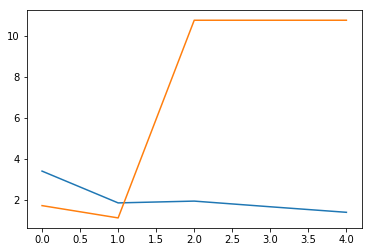

In [92]:
plt.plot(fit_history.history["loss"])
plt.plot(fit_history.history["val_loss"])
plt.show()

In [93]:
#test with one image 
image_path = "test/car/image1.jpg"
image_pil = load_img(image_path)
image_array = img_to_array(image_pil)
image_batch = np.expand_dims(image_array, axis=0)

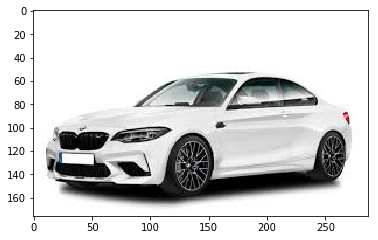

In [94]:
plt.imshow(np.uint8(image_batch[0]))
plt.show()

In [95]:
image_preprocess = preprocess_input(image_batch)

In [96]:
image_predict = model.predict(image_preprocess)

In [106]:
image_predict_index = np.argmax(image_predict)

In [108]:
#for prop,value in vars(test_generator).items():
#    print(prop,"-",value)

image_data_generator - <keras.preprocessing.image.ImageDataGenerator object at 0x7f1a0253bda0>
target_size - (224, 224)
color_mode - rgb
data_format - channels_last
image_shape - (224, 224, 3)
save_to_dir - None
save_prefix - 
save_format - png
interpolation - nearest
split - None
subset - None
directory - test/
classes - [0 0 0 1 1 1 2 2 2]
class_mode - categorical
dtype - float32
samples - 9
num_classes - 3
class_indices - {'car': 0, 'jeep': 1, 'truck': 2}
filenames - ['car/image1.jpg', 'car/image2.jpg', 'car/image3.jpg', 'jeep/image1.jpg', 'jeep/image2.jpg', 'jeep/image3.jpg', 'truck/image1.jpg', 'truck/image2.jpg', 'truck/image3.jpg']
n - 9
batch_size - 1
seed - None
shuffle - True
batch_index - 4
total_batches_seen - 40
lock - <unlocked _thread.lock object at 0x7f1a025e58a0>
index_array - [0 5 7 8 6 4 2 1 3]
index_generator - <generator object Iterator._flow_index at 0x7f1a03091518>


In [112]:
labels = {k:v for v,k in test_generator.class_indices.items()}

In [114]:
print(labels[image_predict_index])

jeep


In [105]:
image_predict_decode = decode_predictions(image_predict)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 3)